# 🎙 Beatbot

#### **GitHub: https://github.com/alexcrist/beatbot**

> What if you could beatbox* into an app that could process the audio, determine which sounds are which, and produce a matching audio track of real drum noises?
>
> From Siri to Google Assistant, a handful of applications have explored and mastered decoding audio into human speech. The push for these kinds of excellent speech processing algorithms has resulted in a wealth of knowledge on the topic from blog posts to academic papers. 
>
> Beatbot uses these documented techniques along with a few novel strategies to analylze audio and replace beatbox sounds with drum sounds.
>
> Here's are a few examples of what it can do.
>
> ** Beatboxing is vocal percussion (i.e.: "pft tss kah tss pft tss kah")*

## 📼 Examples

---

## Part I: Beat location

Beatbot works in three parts with the first part being 'beat location'. In this step, we analyze our beatbox input track and determine the locations of each beat.

Here's an example beatbox audio track.

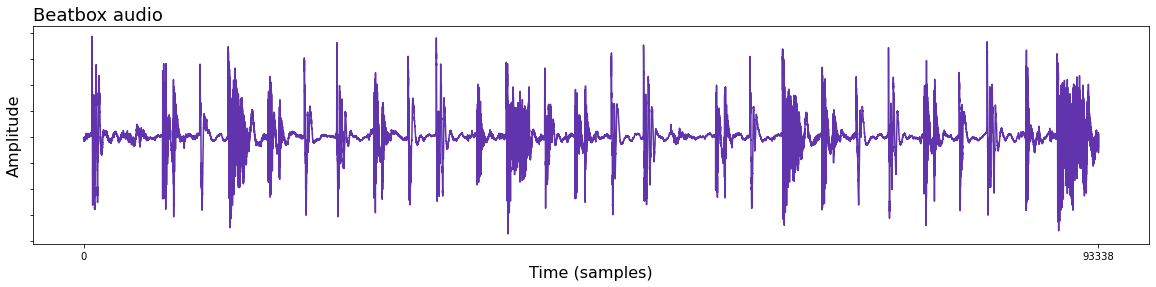

In [1]:
import IPython
import librosa
from utils import plot_utils

%matplotlib inline

BEATBOX_AUDIO_FILE = 'assets/input_audio/beatbox_5.wav'

# Load audio
audio, sample_rate = librosa.load(BEATBOX_AUDIO_FILE, mono=True)

# Plot
plot_utils.plot(y=audio, title='Beatbox audio', xlabel='Time (samples)', ylabel='Amplitude')

# Display audio player
IPython.display.Audio(BEATBOX_AUDIO_FILE)

Visually, we can already begin to see where the beats are located, but the raw waveform is too noisy, contains too many points, and the raw amplitudes of the wave are not representative enough of what we're hearing to easily locate the beats.

To get a get a cleaner representation showing where the beats are, we'll start by taking a look at the the frequencies in this audio track over time. We'll do this by applying the "Fourier transform" to small, overlapping windows of our audio wave.

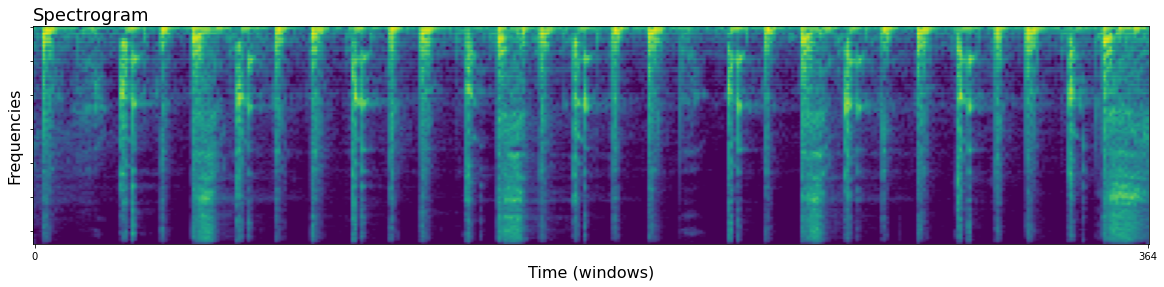

In [2]:
import numpy as np

# Windows of audio 23ms long with 12ms of overlap
WINDOW_SIZE = 512
WINDOW_OVERLAP = 256

# Take the 'short time' Fourier transform of the audio signal
spectrogram = librosa.stft(y=audio, n_fft=WINDOW_SIZE, win_length=WINDOW_SIZE, hop_length=WINDOW_OVERLAP)

# Convert imaginary numbers to real numbers
spectrogram = np.abs(spectrogram)

# Convert from Hz to Mel frequency scale
mel_basis = librosa.filters.mel(sample_rate, WINDOW_SIZE)
spectrogram = np.dot(mel_basis, spectrogram)

# Convert from amplitude to decibels
spectrogram = librosa.amplitude_to_db(spectrogram)

# Plot
plot_utils.heatmap(data=spectrogram, title='Spectrogram', xlabel='Time (windows)', ylabel='Frequencies')

In this visualization of audio frequencies, (known as a spectrogram), we can clearly see where each beat is located. Yellower colors indicate loudness while bluer colors indicate quietness. Positions near the top represent high frequencies, while lower positions show low frequencies.

This representation of our audio data will be more useful to extract beat locations from for a few reasons:
1. We've reduced our number of time values (170,000 to 684)
1. We've clearly represented the frequency data in the audio
1. We've weighted our frequencies according to the Mel scale aligns with human hearing

From here, we can easily determine the volume of the audio over time.

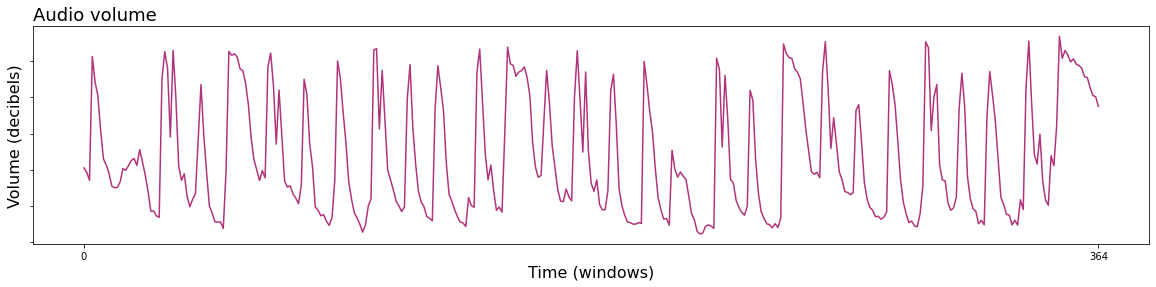

In [3]:
# Sum the spectrogram by column
volume = np.sum(spectrogram, axis=0)

# Plot
plot_utils.plot(volume, title='Audio volume', xlabel='Time (windows)', ylabel='Volume (decibels)')

Summing our spectrogram by column gives us the volume of the beatbox track over time. 

In this representation, we see clear peaks at each beat in the audio track. If we knew the minimum prominence of these peaks that we want to find the locations of, we could easily find them using SciPy's peak finding utility.

The only problem is that for any given beatbox track, we won't know what prominence value we should choose. To get around this, we'll determine how many peaks exist at many different prominence values.

Most frqeuent number of peaks: 37


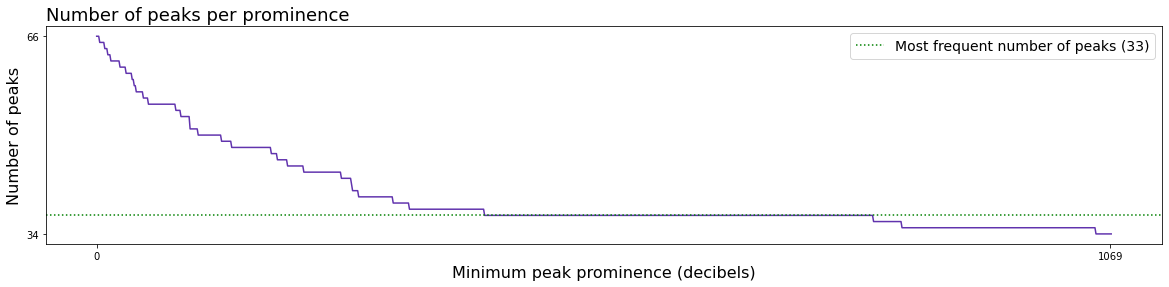

In [4]:
import scipy
import matplotlib.pyplot as plt

MIN_PROMINENCE = 0
MAX_PROMINENCE = np.max(volume) - np.min(volume) / 2 #TODO: Don't divid  by 2
NUM_PROMINENCES = 1000

# Create an array of prominence values
prominences = np.linspace(MIN_PROMINENCE, MAX_PROMINENCE, NUM_PROMINENCES)

# For each prominence value, calculate the # of peaks of at least that prominence
num_peaks = []
for prominence in prominences:
    peak_data = scipy.signal.find_peaks(volume, prominence=prominence)
    num_peaks.append(len(peak_data[0]))
    
# Calculate the most frequent peak quantity
most_frequent_num_peaks = np.argmax(np.bincount(num_peaks)) 
print('Most frqeuent number of peaks:', most_frequent_num_peaks)

#Plot
plot_utils.plot(
    x=prominences,
    y=num_peaks,
    title='Number of peaks per prominence',
    xlabel='Minimum peak prominence (decibels)',
    ylabel='Number of peaks',
    show_yticks=True,
    show=False
)
line = plt.axhline(most_frequent_num_peaks, c='green', ls=':')
plt.legend([line], ['Most frequent number of peaks (33)'], fontsize=14)
plt.show()

Starting at a prominence value of zero and going up to the maximum prominence found in our volume signal, we've determined how many peaks exist for 1000 evenly spaced prominence values.

In our visualization, we can see that a long flat line exists where the prominence value is  changing but the number of peaks does not change. This indicates to us that this number of peaks value (33) represents the most significant peaks in our volume signal.

Using this number of peaks, we can once again use SciPy's peak finding utillity to determine their starting and ending locations.

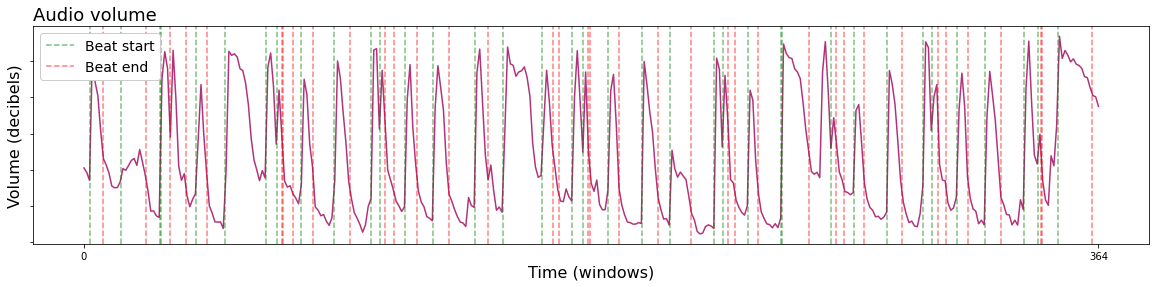

In [5]:
# Define the starts and ends of peak to be the intersection of 80% of the peak's prominence
PROMINENCE_MEASURING_POINT = 0.8

# Get a prominence value for which there are 33 peaks
prominence_index = np.where(np.array(num_peaks) == most_frequent_num_peaks)[0][0]
prominence = prominences[prominence_index]

# Calculate starts and ends of each peak
peak_data = scipy.signal.find_peaks(volume, prominence=prominence, width=0, rel_height=PROMINENCE_MEASURING_POINT)
peak_starts = peak_data[1]['left_ips']
peak_ends = peak_data[1]['right_ips']

# Plot
plot_utils.plot(volume, title='Audio volume', xlabel='Time (windows)', ylabel='Volume (decibels)', show=False)
for peak_start, peak_end in zip(peak_starts, peak_ends):
    beat_start = plt.axvline(peak_start, c='green', alpha=0.5, ls='--')
    beat_end = plt.axvline(peak_end, c='red', alpha=0.5, ls='--')
plt.legend([beat_start, beat_end], ['Beat start', 'Beat end'], fontsize=14, framealpha=1)
plt.show()

And boom! Just like that, we have the locations of each beat. The last thing to do is to scale these locations from time windows back up to time samples to use with the original audio wave.

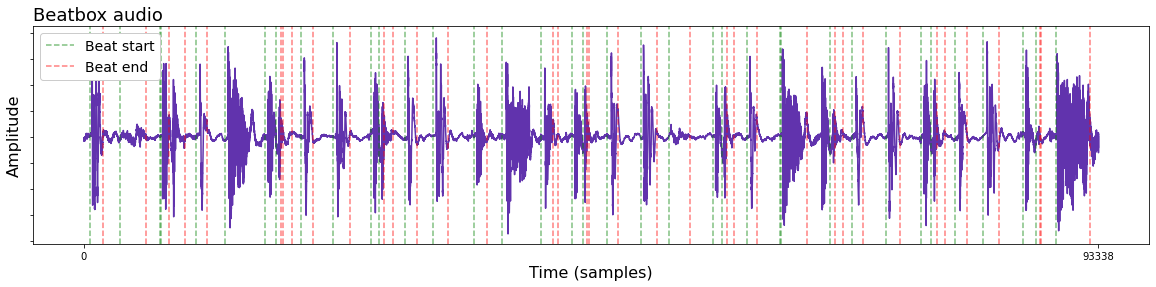

In [6]:
# Scale up peak starts and ends
beat_starts = librosa.frames_to_samples(peak_starts, hop_length=WINDOW_OVERLAP)
beat_ends = librosa.frames_to_samples(peak_ends, hop_length=WINDOW_OVERLAP)

# Plot
plot_utils.plot(y=audio, title='Beatbox audio', xlabel='Time (samples)', ylabel='Amplitude', show=False)
for beat_start, beat_end in zip(beat_starts, beat_ends):
    start_line = plt.axvline(beat_start, c='green', alpha=0.5, ls='--')
    end_line = plt.axvline(beat_end, c='red', alpha=0.5, ls='--')
plt.legend([start_line, end_line], ['Beat start', 'Beat end'], fontsize=14, framealpha=1)
plt.show()

---

## Part II: Beat classification

Now that we the locations of all of the beats in the track, we need to determine which beats are 'the same'. If the beatboxer records audio that sounds like "pft ts kuh ts pft ts kuh ts", the job of the beat classifier is to return the pattern "0 1 2 1 0 1 2 1".

To start off, lets look at our beats.

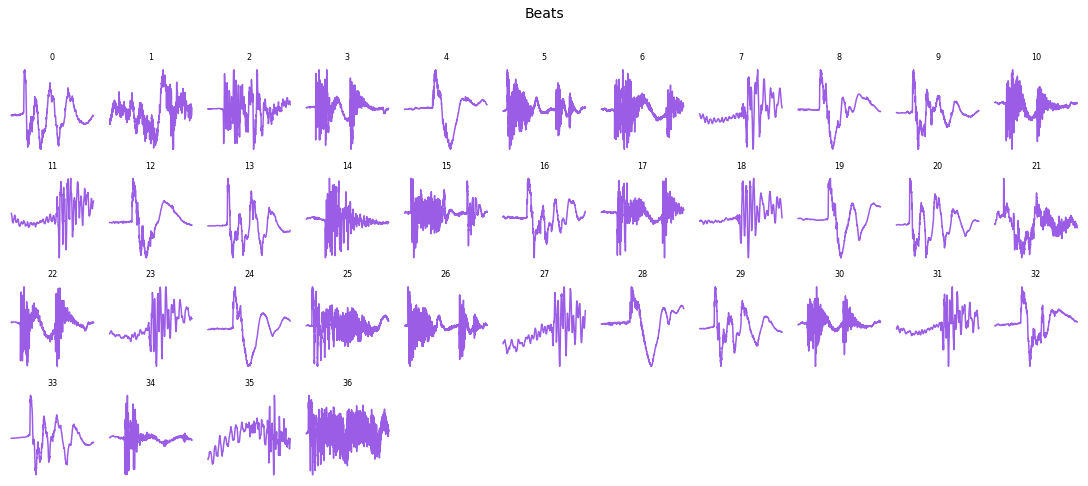

In [7]:
from utils import multi_plot_utils

# Extract beats' audio
beats = []
for beat_start, beat_end in zip(beat_starts, beat_ends):
    beat = audio[beat_start:beat_end]
    beats.append(beat)

# Plot
multi_plot_utils.multi_plot(beats, title='Beats')

Listening to the audio again, our expected beat pattern should be [ 0 1 1 1 2 1 1 1 1 1 0 1 2 1 1 1 0 1 1 1 2 1 1 1 1 1 0 1 2 1 1 1 3 ]. 

Key:
* 0 = "pft"
* 1 = "tss"
* 2 = "khh"
* 3 = Unintentional knock

Lets visualize this.

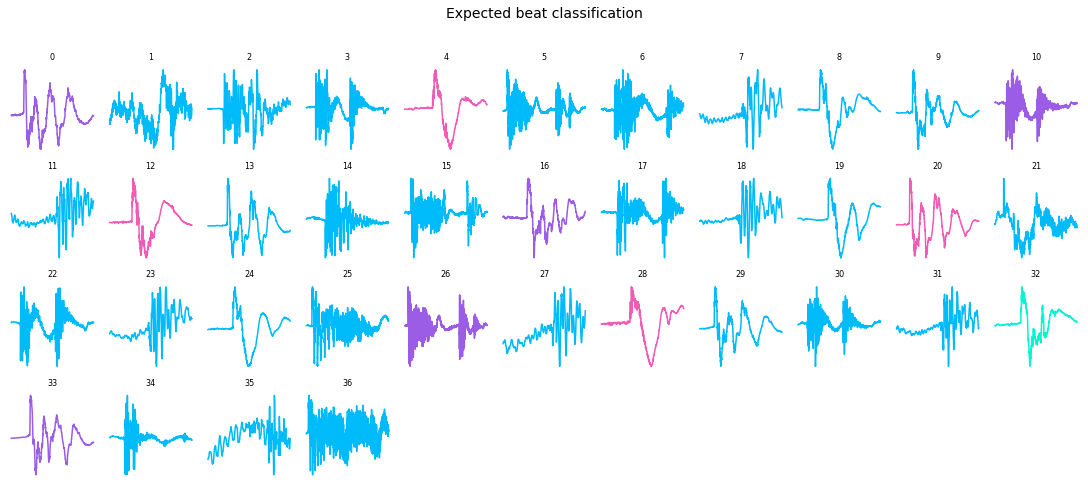

In [8]:
EXPECTED_PATTERN = [0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 3]

# Plot
multi_plot_utils.multi_plot(beats, title='Expected beat classification', pattern=EXPECTED_PATTERN)

# Also here's the audio if you want to listen again
IPython.display.Audio(BEATBOX_AUDIO_FILE)

Our first task is to 'featurize' our beats in some way that will let us compare them to eachother for similarity. A proven audio featurization popular in speech processing algorithms are "Mel-frequency cepstral coefficients" (MFCCs).

MFCCs are 2D vectors that are created in three steps. 
1. The input audio is windowed and transformed into its frequency comopnents via the Fourier transform
1. Mel-coefficients are extracted from each set of frequencies in time (the Mel scale is essentially the human hearing scale)
1. These values are compressed usually using the inverse discrete cosine transform

A resource that I used to better understand MFCCs can be found here: http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

Lets extract some MFCCs from our beats now.

/home/alexcrist/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=780
  warnings.warn(
/home/alexcrist/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=449
  warnings.warn(
/home/alexcrist/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=445
  warnings.warn(
/home/alexcrist/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=412
  warnings.warn(
/home/alexcrist/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=981
  warnings.warn(
/home/alexcrist/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=518
  w

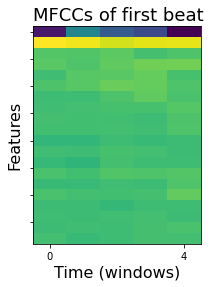

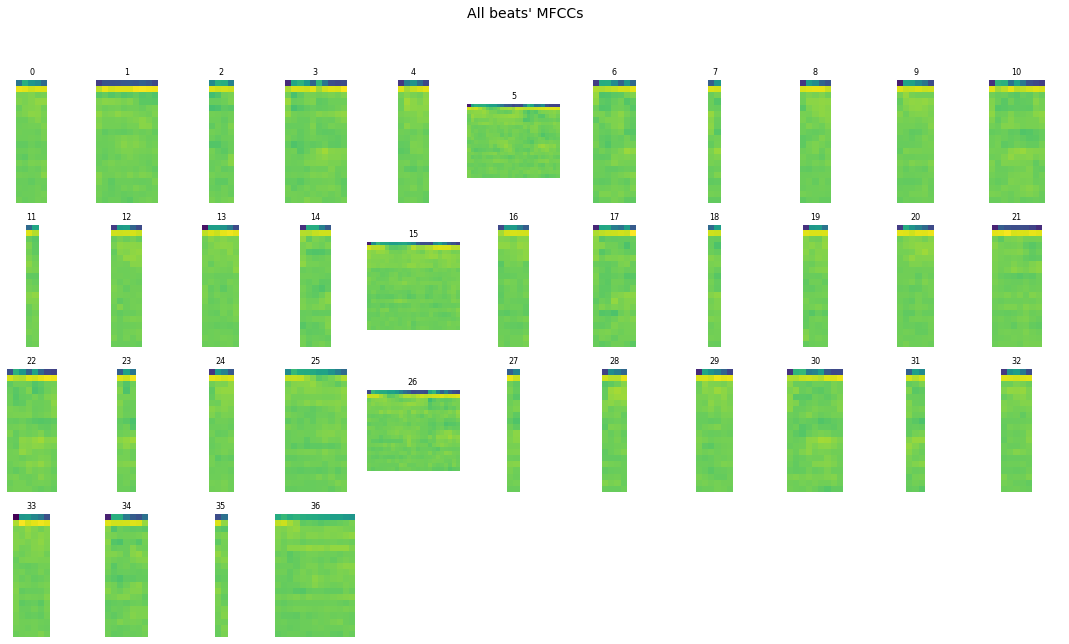

In [9]:
# From each beat, create a set of MFCCs
mfccs = []
for beat in beats:
    mfcc = librosa.feature.mfcc(
        beat, 
        win_length=WINDOW_SIZE, 
        hop_length=WINDOW_OVERLAP,
        n_fft=1024
    )
    mfccs.append(mfcc)

# Plot
plot_utils.heatmap(mfccs[0], figsize=(3, 4), title='MFCCs of first beat', xlabel='Time (windows)', ylabel='Features')
multi_plot_utils.multi_heatmap(mfccs, title='All beats\' MFCCs')

These featurizations may all look the same, but if you look closely, you can actually see subtle similarities in the beats that should be classified as the same sound.

Next we'll look to compare each beat's MFCCs to every other beat's MFCCs. One challenge here is that not all beats' MFCCs have the same width. This is because not all our beats were the same length timewise.

To effectively compare sets of features with different widths, we'll use a technique called Dynamic Time Warping (DTW). 

In Dynamic Time Warping, the nth column of one item does not need to be matched with the nth column of the item its being compared to. The below image demonstrates this: 

<img src="assets/dtw.jpeg" style="height: 600px" />

Image source: https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd

Now, using DTW, let's measure the distance between each pair of beats. We'll store this result in a distance matrix.

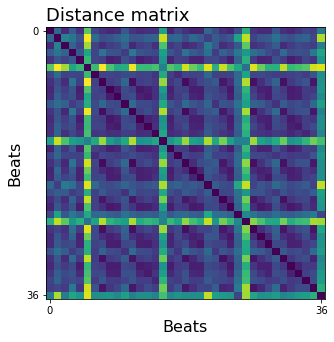

In [10]:
# Create a distance matrix measuring the distance between each pair of beats' MFCCs
distance_matrix = np.full((len(mfccs), len(mfccs)), -1)
for i in range(len(mfccs)):
    for j in range(len(mfccs)):
        
        # If we are comparing a MFCC set to itself, distance is 0
        if i == j:
            distance_matrix[i][j] = 0
            
        # If we haven't calculated the distance already, calculate it
        elif distance_matrix[i][j] == -1:
            distance = librosa.sequence.dtw(mfccs[i], mfccs[j])[0][-1][-1]
            distance_matrix[i][j] = distance
            distance_matrix[j][i] = distance

# Plot
plot_utils.heatmap(distance_matrix, figsize=(5, 5), title='Distance matrix', xlabel='Beats', ylabel='Beats', show_yticks=True)

In this visualization, a dark pixel at coordinate (x, y) indicates that beat x and beat y are similar. A yellow pixel indicates dissimilarity.

Now that we know how similar each beat is to every other beat, we can use a clustering algorithm to group together similar beats. I chose to use hierarchical clustering for this.

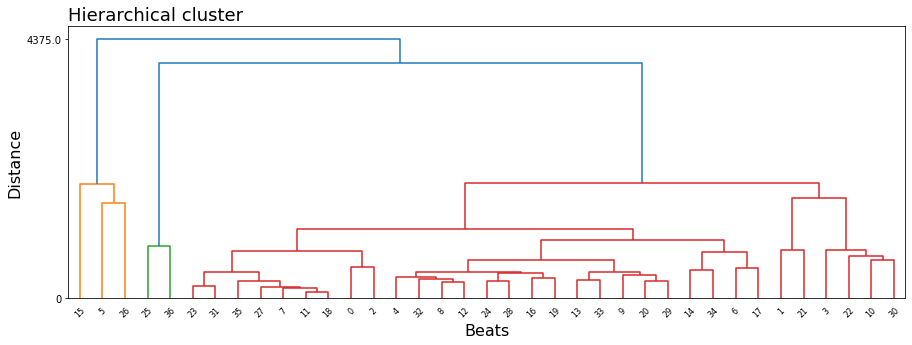

In [11]:
import scipy.cluster

# Create hierarchical cluster of beats
condensed_matrix = scipy.spatial.distance.squareform(distance_matrix)
cluster_data = scipy.cluster.hierarchy.linkage(condensed_matrix, 'complete')
max_distance = cluster_data[:,2][-1]

# Plot
plot_utils.plot([0], figsize=(15, 5), title='Hierarchical cluster', xlabel='Beats', ylabel='Distance', show=False)
ax = plt.gca()
ax.set_yticks([0, max_distance])
ax.set_yticklabels([0, max_distance])
scipy.cluster.hierarchy.dendrogram(cluster_data, ax=ax)
plt.show()

The above figure is a dendrogram; it represents many clustering possibilities. 

To obtain a single clustering from this diagram, you make a single horizontal cut across the chart. Every vertical branch that instersects the cut represents one cluster. All the nodes connected to a cut branch belong to the same.

The flexibility here is great because for any given beatbox track, we won't know how many different kinds of beats are being used. It does pose the question though, what is the 'right' number of clusters?

One method of determining this is by looking at how the number of clusters changes as we change the position of our cut.

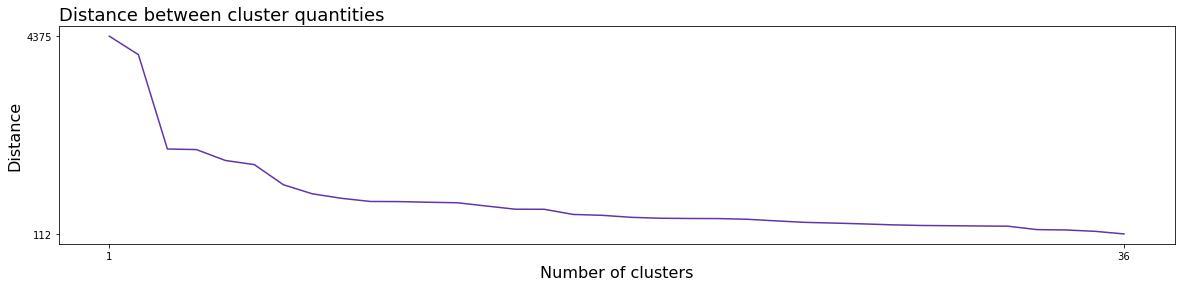

In [12]:
# Extract cluster distances from the cluster data
cluster_distances = cluster_data[::-1,2]
num_clusters = range(1, len(cluster_distances) + 1)

# Plot
plot_utils.plot(
    x=num_clusters, 
    y=cluster_distances, 
    title='Distance between cluster quantities', 
    xlabel='Number of clusters',
    ylabel='Distance',
    show_yticks=True
)

The above chart shows that as you change the position of the cut in the dendrogram, the number of clusters formed changes.


From here, a popular method to determine a good cluster quantity is to look for "knee points" in this graph. These knee points are defined by maxima in the second degree differential.

More info on that here: https://stackoverflow.com/a/21723473/4762063

Let's take a look at that.

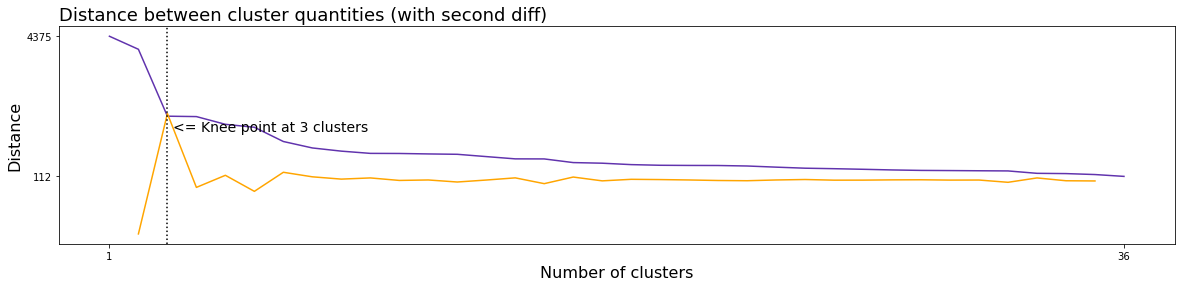

In [18]:
# Calculate the second differential line
second_diff = np.diff(cluster_distances, 2)
num_clusters_second_diff = num_clusters[1:-1]
cluster_quantity = np.argmax(second_diff[1:]) + 1 + num_clusters_second_diff[0] # TODO: CHange back

# Plot
plot_utils.plot(
    x=num_clusters, 
    y=cluster_distances, 
    title='Distance between cluster quantities (with second diff)', 
    xlabel='Number of clusters',
    ylabel='Distance',
    show_yticks=True,
    show=False
)
plt.plot(num_clusters[1:-1], second_diff, c='orange')
plt.axvline(cluster_quantity, c='black', ls=':')
plt.text(x=3.2, y=1500, s='<= Knee point at ' + str(cluster_quantity) + ' clusters', fontsize=14)
plt.show()

cluster_quantity = 5 # TODO

The maximum value in the second differential shows us where the most extreme knee point is in our original line. This point proves to yield a good cluster quantity.

Now, cutting our dendrogram such that we get exctly three clusters, lets look at which beats belong to which cluster.

Pattern: [4 5 4 5 4 1 4 4 4 4 5 4 4 4 4 2 4 4 4 4 4 5 5 4 4 3 1 4 4 4 5 4 4 4 4 4 3]


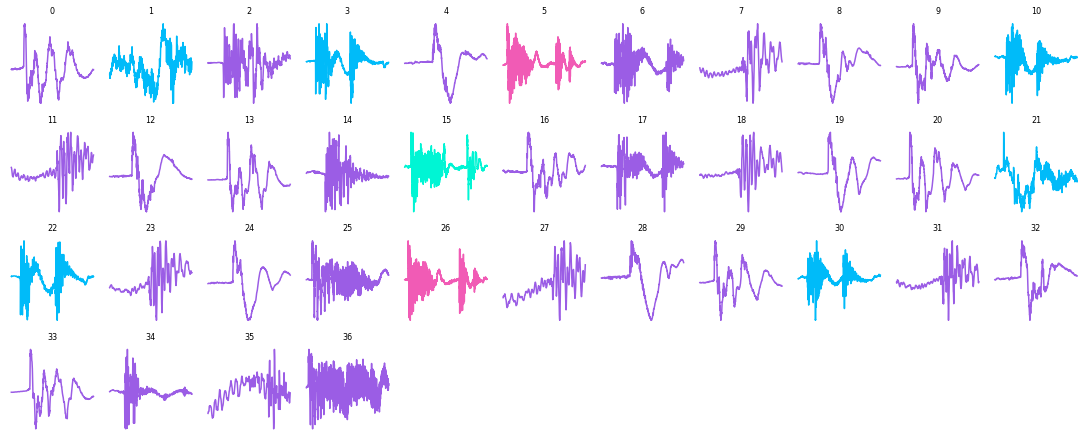

In [19]:
# For our chosen cluster quantity, retrieve the cluster pattern
pattern = scipy.cluster.hierarchy.fcluster(
    cluster_data, 
    cluster_quantity, 
    'maxclust'
)
print('Pattern:', pattern)

# Plot
multi_plot_utils.multi_plot(beats, title='', pattern=pattern)

Pretty good! This closely matches our desired classification. The only misclassification is beat #32 which is the unintentional knock noise. Looks like our algorithm determined that it belonged with the "pft" sounds.

---

## Part III: Beat replacement

At this point, we've done most of the heavy lifting. All that remains is to replace the beatbox sounds with drum kit sounds. I've curated 50 different drum kit sounds to choose from.

To produce an aesthetic output track, we can once again use MFCCs to determine which drum noise sounds to closest to the beatbox noise it will replace.

Let's do that for our three different beats ("pft", "tss", and "khh").

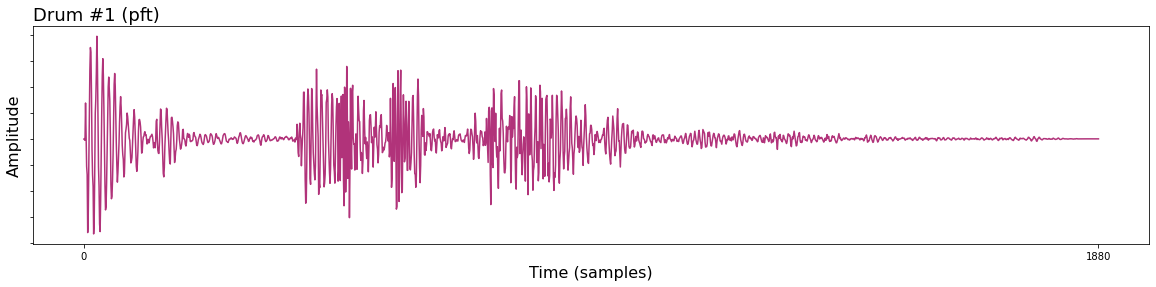

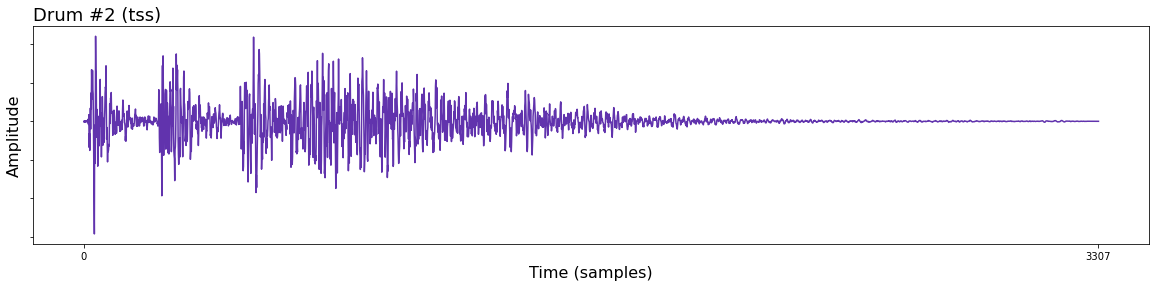

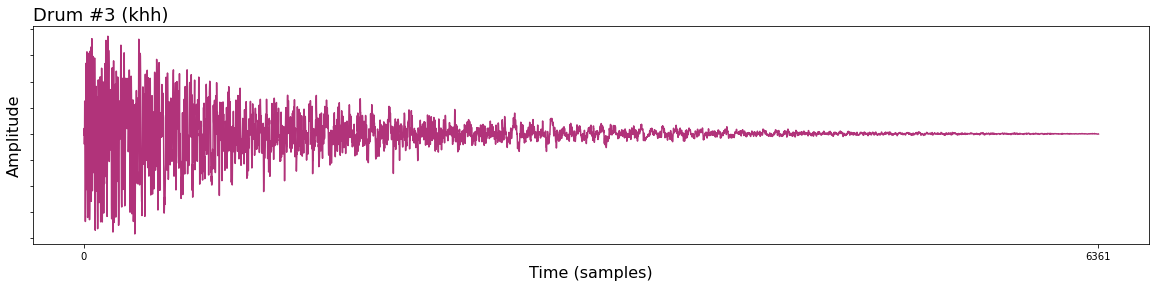

In [20]:
import os

DRUM_FOLDER = 'assets/drums/'

# Get all drum kit file paths
drum_files = os.listdir(DRUM_FOLDER)

# Extract MFCCs from each drum kit sound
drum_sounds = []
drum_mfccs = []
for file in drum_files:
    audio, sample_rate = librosa.load(DRUM_FOLDER + file)
    mfcc = librosa.feature.mfcc(
        audio,
        win_length=WINDOW_SIZE, 
        hop_length=WINDOW_OVERLAP,
        n_fft=1024
    )
    drum_sounds.append(audio)
    drum_mfccs.append(mfcc)

# Create a map from beatbox sound classifications to drum kit sounds
beatbox_to_drum_map = {}

# Keep track of which drum sounds we've used to avoid repeats
drums_used = []

for beat_mfcc, classification in zip(mfccs, pattern):
    if classification not in beatbox_to_drum_map:
        
        # Find the drum kit sound most similar to the beatbox sound
        best_distance = float('inf')
        best_drum_sound = None
        best_drum_file = None
        for drum_sound, drum_mfcc, drum_file in zip(drum_sounds, drum_mfccs, drum_files):
            
            # No repeats allowed
            if drum_file in drums_used:
                continue
            
            # Calculate distance using previous DTW approach
            distance = librosa.sequence.dtw(beat_mfcc, drum_mfcc)[0][-1][-1]
            if distance < best_distance:
                best_distance = distance
                best_drum_sound = drum_sound
                best_drum_file = drum_file
            
        # Update drum map
        beatbox_to_drum_map[classification] = best_drum_sound
        drums_used.append(best_drum_file)
        
# Plot
drum_sounds = beatbox_to_drum_map.values()
for index, (drum_sound, spelling) in enumerate(zip(drum_sounds, ["pft", "tss", "khh"])):
    plot_utils.plot(
        drum_sound, 
        title='Drum #' + str(index + 1) + ' (' + spelling + ')', 
        xlabel='Time (samples)', 
        ylabel='Amplitude'
    )
    IPython.display.display(IPython.display.Audio(data=drum_sound, rate=sample_rate))

Great! Now that we have our sounds, all thats left to do is assemble them into a track.

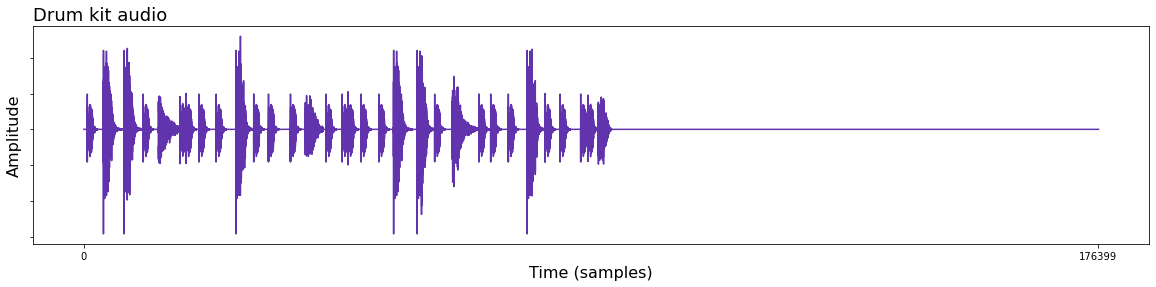

Final product:


And the original again:


In [21]:
# Create 8 seconds of empty audio
track = np.zeros(sample_rate * 8)

# Add drum sounds to the track
for beat_start, classification in zip(beat_starts, pattern):
    drum_sound = beatbox_to_drum_map[classification]
    drum_sound = np.concatenate([
        np.zeros(beat_start),
        drum_sound,
        np.zeros(len(track) - len(drum_sound) - beat_start)
    ])
    track += drum_sound
    
# Plot
plot_utils.plot(track, title='Drum kit audio', xlabel='Time (samples)', ylabel='Amplitude')
print('Final product:')
IPython.display.display(IPython.display.Audio(data=track, rate=sample_rate))
print('And the original again:')
IPython.display.display(IPython.display.Audio(BEATBOX_AUDIO_FILE))

And we're done!

In [17]:
import soundfile as sf
sf.write('assets/output_audio/drum_track_5.wav', track, sample_rate)